In [1]:
import pandas as pd 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

In [2]:
data = pd.read_csv("_immunization_disparities_dataset.csv")

In [3]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [4]:
data.drop_duplicates(inplace=True)

In [5]:
from sklearn.preprocessing import RobustScaler , MinMaxScaler
categorical_cols = X.select_dtypes(exclude="number").columns.tolist()
numerical_cols = X.select_dtypes(include="number").columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', 'passthrough', categorical_cols)
    ],
    remainder='drop'
)

label_encoders = {col: LabelEncoder() for col in categorical_cols}

def encode_labels(X):
    for col in categorical_cols:
        X[col] = label_encoders[col].fit_transform(X[col])
    return X

pipeline = Pipeline(steps=[
    ('label_encoding', FunctionTransformer(encode_labels, validate=False)),
    ('preprocessor', preprocessor)
])

In [6]:
X_transformed = pipeline.fit_transform(X)

In [7]:
pipeline

Pipeline(steps=[('label_encoding',
                 FunctionTransformer(func=<function encode_labels at 0x00000120B4FD89A0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Age']),
                                                 ('cat', 'passthrough',
                                                  ['Gender', 'Region', 'State',
                                                   'Community'])]))])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from skopt.space import Integer, Real, Categorical
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, 
                              RandomForestClassifier, VotingClassifier)
from skopt import BayesSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

model_params = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'C': Real(0.001, 100, prior='uniform'),
            'penalty': Categorical(['l1', 'l2']),
            'max_iter': Integer(100, 300),
            'tol': Real(1e-5, 1e-1, prior='log-uniform')
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': Integer(100, 300),
            'max_depth': Categorical([None, 10, 20, 30]),
            'min_samples_split': Integer(2, 10),
            'min_samples_leaf': Integer(1, 4),
            'max_features': Categorical(['sqrt', 'log2']),
            'bootstrap': Categorical([True, False]),
            'criterion': Categorical(['gini', 'entropy'])
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': Integer(100, 200),
            'learning_rate': Real(0.01, 0.2, prior='uniform'),
            'max_depth': Integer(3, 5),
            'min_samples_split': Integer(2, 5),
            'subsample': Real(0.8, 1.0, prior='uniform'),
             'loss': Categorical(['log_loss', 'exponential']),
            'max_features': Categorical(['sqrt', 'log2', None])
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': Integer(100, 200),
            'learning_rate': Real(0.01, 0.2, prior='uniform'),
            'max_depth': Integer(3, 7),
            'gamma': Real(0, 0.3, prior='uniform'),
            'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
            'subsample': Real(0.5, 1.0),
            'reg_alpha': Real(0.0, 1.0),
            'reg_lambda': Real(0.0, 1.0)
        }
    },
    'LGBMClassifier': {
        'model': LGBMClassifier(),
        'params': {
            'n_estimators': Integer(100, 300),
            'learning_rate': Real(0.01, 0.2, prior='uniform'),
            'num_leaves': Integer(31, 127),
            'max_depth': Integer(-1, 10),
            'min_data_in_leaf': Integer(20, 100),
            'lambda_l1': Real(0.0, 0.5, prior='uniform'),
            'lambda_l2': Real(0.0, 0.5, prior='uniform'),
            'bagging_fraction': Real(0.5, 1.0),
            'bagging_freq': Integer(1, 10)
        }
    },
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': Integer(50, 200),
            'learning_rate': Real(0.01, 1.0, prior='uniform')
        }
    },
    'CatBoostClassifier': {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'iterations': Integer(100, 200),
            'depth': Integer(3, 7),
            'learning_rate': Real(0.01, 0.2, prior='uniform'),
            'l2_leaf_reg': Integer(3, 10),
            "border_count": Integer(32, 255),
            "bagging_temperature": Real(0.0, 1.0)
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': Real(0.1, 10, prior='uniform'),
            'kernel': Categorical(['linear', 'rbf']),
            "gamma": Categorical(['scale', "auto"]),
            "degree": Integer(2, 5)
        }
    },
}

In [16]:
def run_bayes_search(X_train, y_train, model, params):
    bayes_search = BayesSearchCV(model, params, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    bayes_search.fit(X_train, y_train)
    return bayes_search

Running BayesSearch for LogisticRegression
Best parameters (BayesSearchCV) for LogisticRegression: OrderedDict({'C': 41.010985781372526, 'max_iter': 246, 'penalty': 'l2', 'tol': 0.00018331515651137157})
Accuracy (BayesSearchCV) for LogisticRegression: 0.776
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       285
           1       0.74      0.75      0.74       215

    accuracy                           0.78       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.78      0.78      0.78       500

Confusion Matrix for LogisticRegression:



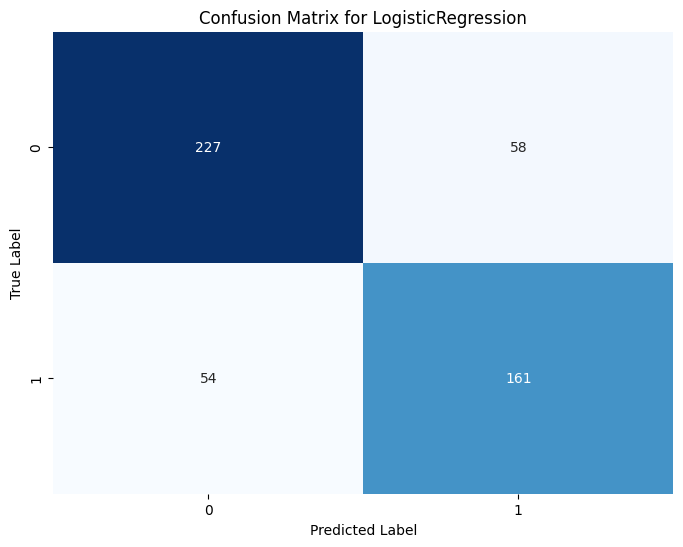

Running BayesSearch for RandomForestClassifier
Best parameters (BayesSearchCV) for RandomForestClassifier: OrderedDict({'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 251})
Accuracy (BayesSearchCV) for RandomForestClassifier: 0.806
Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       285
           1       0.78      0.76      0.77       215

    accuracy                           0.81       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.81      0.81      0.81       500

Confusion Matrix for RandomForestClassifier:



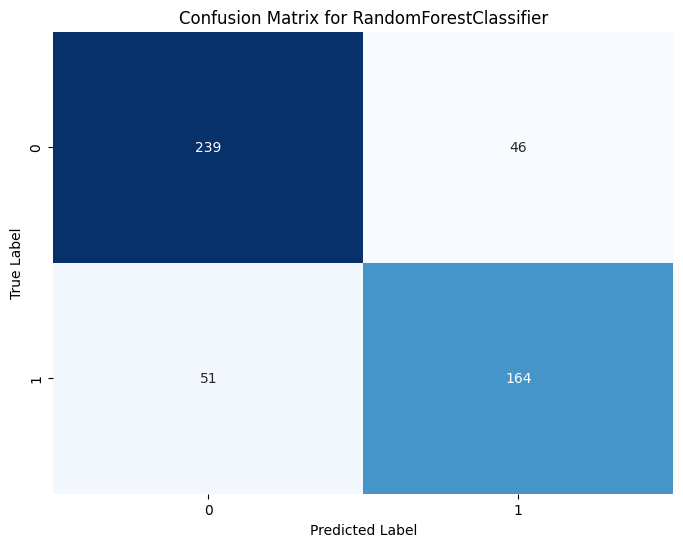

Running BayesSearch for GradientBoostingClassifier
Best parameters (BayesSearchCV) for GradientBoostingClassifier: OrderedDict({'learning_rate': 0.09451817733721884, 'loss': 'exponential', 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 145, 'subsample': 0.8310896108101087})
Accuracy (BayesSearchCV) for GradientBoostingClassifier: 0.824
Classification Report for GradientBoostingClassifier:

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       285
           1       0.82      0.76      0.79       215

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500

Confusion Matrix for GradientBoostingClassifier:



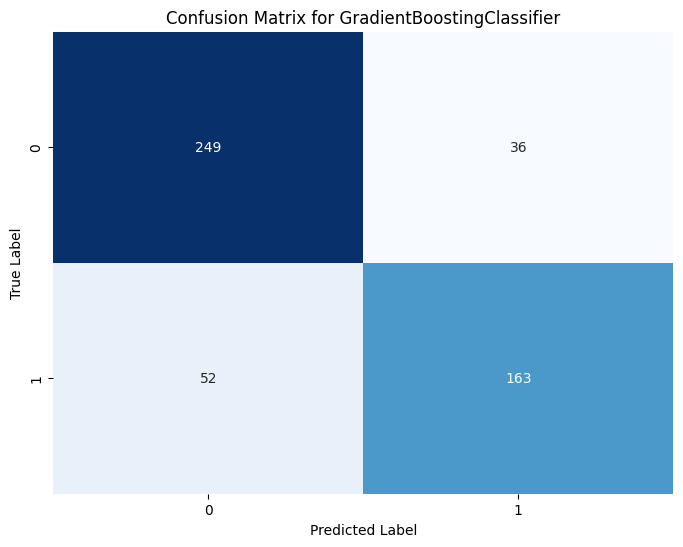

Running BayesSearch for XGBClassifier
Best parameters (BayesSearchCV) for XGBClassifier: OrderedDict({'colsample_bytree': 0.8670140089927842, 'gamma': 0.2818109212808315, 'learning_rate': 0.04108536394132455, 'max_depth': 4, 'n_estimators': 180, 'reg_alpha': 0.37257977798325786, 'reg_lambda': 0.4590245141508057, 'subsample': 0.7673825800605678})
Accuracy (BayesSearchCV) for XGBClassifier: 0.818
Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       285
           1       0.82      0.74      0.78       215

    accuracy                           0.82       500
   macro avg       0.82      0.81      0.81       500
weighted avg       0.82      0.82      0.82       500

Confusion Matrix for XGBClassifier:



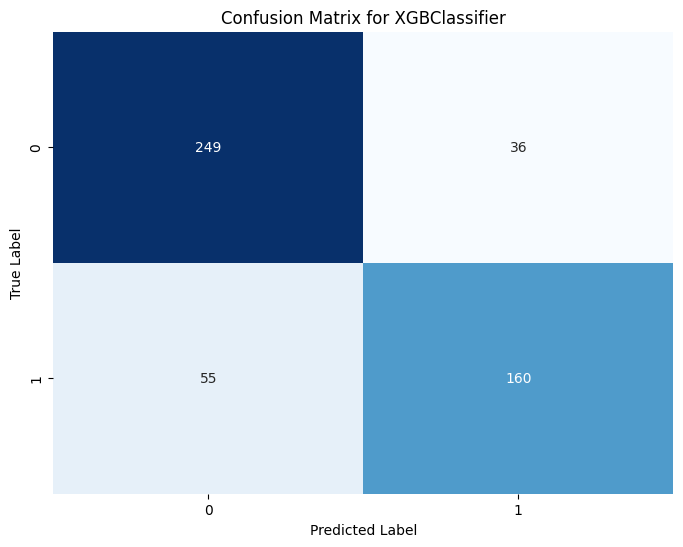

Running BayesSearch for LGBMClassifier
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=0.46643399942391695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46643399942391695
[LightGBM] [Warning] lambda_l2 is set=0.15789979674352436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15789979674352436
[LightGBM] [Warning] bagging_fraction is set=0.705051979426657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.705051979426657
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] lambda_l1 is set=0.46643399942391695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46643399942391695
[LightGBM] [Warning] lambda_l2 is set=0.15789979674352436,

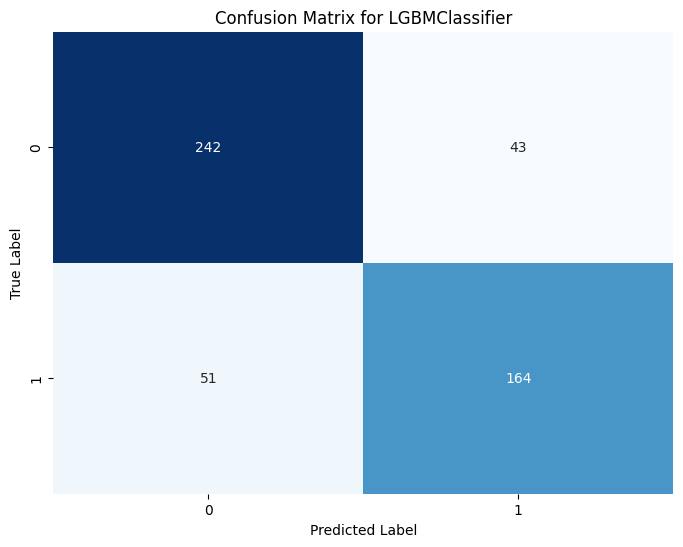

Running BayesSearch for AdaBoostClassifier


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is depr

Best parameters (BayesSearchCV) for AdaBoostClassifier: OrderedDict({'learning_rate': 0.8390144719977516, 'n_estimators': 182})
Accuracy (BayesSearchCV) for AdaBoostClassifier: 0.82
Classification Report for AdaBoostClassifier:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       285
           1       0.80      0.77      0.79       215

    accuracy                           0.82       500
   macro avg       0.82      0.81      0.82       500
weighted avg       0.82      0.82      0.82       500

Confusion Matrix for AdaBoostClassifier:



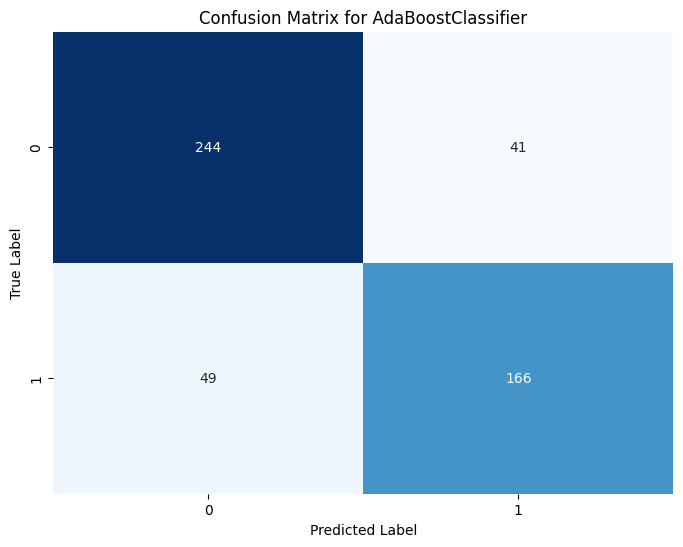

Running BayesSearch for CatBoostClassifier
Best parameters (BayesSearchCV) for CatBoostClassifier: OrderedDict({'bagging_temperature': 0.44483251230115184, 'border_count': 237, 'depth': 3, 'iterations': 143, 'l2_leaf_reg': 4, 'learning_rate': 0.0961964153231968})
Accuracy (BayesSearchCV) for CatBoostClassifier: 0.828
Classification Report for CatBoostClassifier:

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       285
           1       0.83      0.75      0.79       215

    accuracy                           0.83       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.83      0.83      0.83       500

Confusion Matrix for CatBoostClassifier:



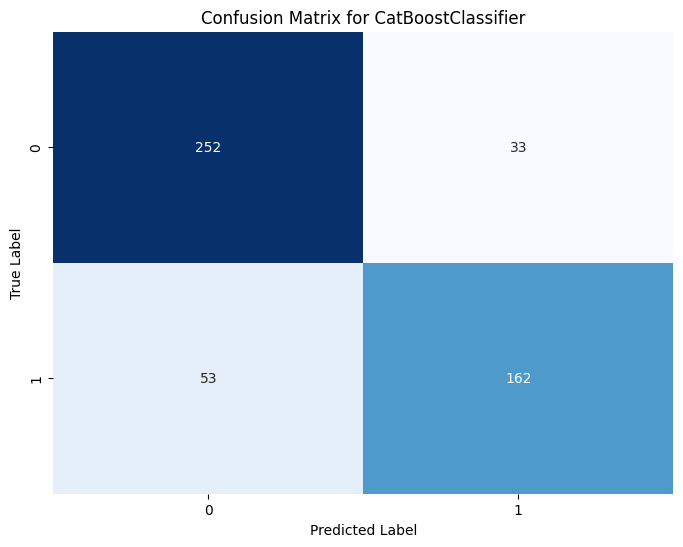

Running BayesSearch for SVC
Best parameters (BayesSearchCV) for SVC: OrderedDict({'C': 8.390144719977515, 'degree': 5, 'gamma': 'scale', 'kernel': 'rbf'})
Accuracy (BayesSearchCV) for SVC: 0.766
Classification Report for SVC:

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       285
           1       0.71      0.77      0.74       215

    accuracy                           0.77       500
   macro avg       0.76      0.77      0.76       500
weighted avg       0.77      0.77      0.77       500

Confusion Matrix for SVC:



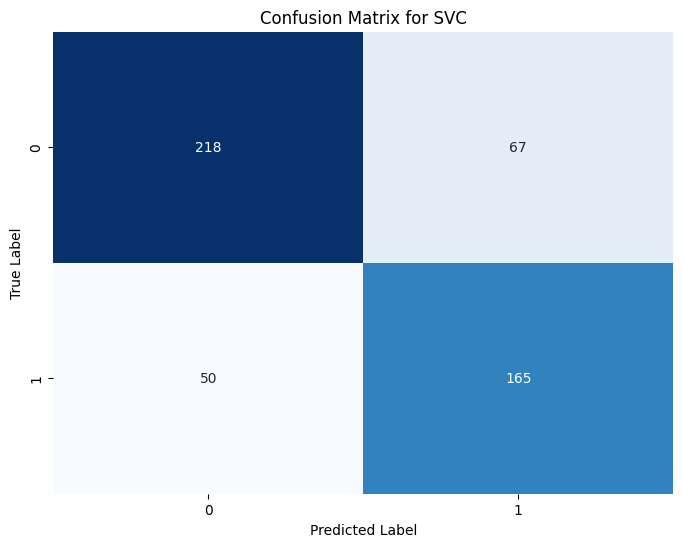

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

for model_name, mp in model_params.items():
    print(f"Running BayesSearch for {model_name}")
    result_random =  run_bayes_search(X_train, y_train, mp['model'], mp['params'])
    print(f"Best parameters (BayesSearchCV) for {model_name}: {result_random.best_params_}")
    y_pred = result_random.predict(X_test)
    print(f"Accuracy (BayesSearchCV) for {model_name}: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {model_name}:\n")
    plot_confusion_matrix(cm, model_name)


In [26]:
estimators = [
    ('random_forest', RandomForestClassifier(max_depth= 30, max_features='sqrt', min_samples_leaf= 3, min_samples_split= 8, n_estimators= 281)),
    ('adaboost', AdaBoostClassifier(algorithm='SAMME',learning_rate= 0.955923206446829, n_estimators= 155)),
    ('catboost', CatBoostClassifier(verbose=0)),
]
vot_clf = VotingClassifier(estimators=estimators, voting='hard')
vot_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(max_depth=30,
                                                     min_samples_leaf=3,
                                                     min_samples_split=8,
                                                     n_estimators=281)),
                             ('adaboost',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=0.955923206446829,
                                                 n_estimators=155)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x00000120F0BBD2B0>)])

In [27]:
y_pred = vot_clf.predict(X_test)
print(f"voting_clf: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report for voting_clf\n")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for voting_clf:\n")
cm

voting_clf: 0.82
Classification Report for voting_clf

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       285
           1       0.81      0.76      0.78       215

    accuracy                           0.82       500
   macro avg       0.82      0.81      0.81       500
weighted avg       0.82      0.82      0.82       500

Confusion Matrix for voting_clf:



array([[247,  38],
       [ 52, 163]], dtype=int64)